In [1]:
import sys
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
from torch_geometric.data import Dataset, download_url, Data
import pandas as pd
import shutil
import torch
from scipy.spatial import distance

from torch_geometric import nn as gnn
import torch.nn.functional as F
from torchvision.transforms.functional import crop
from torch import nn



from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from torch.nn import Sequential as Seq

from tqdm import tqdm

sys.path.append('/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation')
from onegraph_rest_free_graphds import OneGraphDS
from gan_based_models import Discriminator
from second_stage_vig_based_models import FullModel
from vig_based_functions import act_layer, get_multi_shot_set
from vig_graph_modules import GrapherSetEdges, FFN
from perceptual_loss import VGGPerceptualLoss

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing f

In [ ]:
with open('/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/split_eye_tile_dataset.pickle', 'rb') as handle:
    data = pickle.load(handle)

train_tiles = data["train_tiles"]
test_tiles = data["test_tiles"]
train_cluster = data["train_cluster"]
test_cluster = data["test_cluster"]
train_img_ind = data["train_img_ind"]
test_img_ind = data["test_img_ind"]

print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(train_img_ind.shape)
print(test_img_ind.shape)

torch.Size([773, 56, 56, 3])
torch.Size([266, 56, 56, 3])
torch.Size([773])
torch.Size([266])
torch.Size([773])
torch.Size([266])


In [3]:
patch_distances = {"train":None, "test":None}

with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/train_patch_distances.pk1', 'rb') as handle:
    patch_distances["train"] = pickle.load(handle)
    
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_patch_distances.pk1', 'rb') as handle:
    patch_distances["test"] = pickle.load(handle)

# Load data before process and split

In [5]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_202_with_tiles_processed.pk1', 'rb') as handle:
    data = pickle.load(handle)

In [6]:
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/all_patch_distances.pk1', 'rb') as handle:
    patch_distances = pickle.load(handle)

In [4]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

array([ 240, 1824,  152,   93,   80,   60,  231,  115,  163,   66,   93,
        115])

In [5]:
data["all_tiles"].shape

(3232, 56, 56, 3)

# Data Processing

## LW Ind Implemented

In [7]:
A, T, _, _, _ = data["tiles"].shape

lw_ind = np.where(np.array([np.sum(x == 255)/(56*56*3) for x in data["all_tiles"]]) <=0.4)[0]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 0)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 3)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 12)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]

lw_ind = lw_ind[np.where(pos_ind != 15)[0]]

pos_ind = [[x for x in range(T)] for _ in range(A)]
pos_ind = torch.Tensor(np.array(pos_ind)).flatten().to(torch.int)
pos_ind = pos_ind[lw_ind]
data["tile_cluster"] = data["tile_cluster"][lw_ind]
data["all_tiles"] = data["all_tiles"][lw_ind]

img_ind = [[x for _ in range(T)] for x in range(A)]

img_ind = torch.Tensor(np.array(img_ind)).flatten().to(torch.int)

img_ind = img_ind[lw_ind]

In [7]:
print(lw_ind.shape)
print(pos_ind.shape)
print(img_ind.shape)
print(data["tile_cluster"].shape)
print(data["all_tiles"].shape)

(1039,)
torch.Size([1039])
torch.Size([1039])
(1039,)
(1039, 56, 56, 3)


In [8]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

array([103, 131, 146,  73,  74,  58,  73,  66,  42,  66,  93, 114])

In [9]:
unique, counts = np.unique(pos_ind, return_counts=True)
for x in zip(unique, counts):
    print(x)


(1, 24)
(2, 14)
(4, 53)
(5, 181)
(6, 191)
(7, 63)
(8, 53)
(9, 187)
(10, 187)
(11, 37)
(13, 26)
(14, 23)


In [10]:
unique, counts = np.unique(img_ind, return_counts=True)
counts

array([ 4,  3,  3,  2,  5,  3,  3,  4,  2,  2,  4,  4,  3,  4,  4,  2,  3,
        3,  4,  5,  2,  3,  3,  2,  3,  4,  4,  4,  4, 10,  8,  8,  8,  8,
       10,  8,  2,  8,  4,  8, 11,  8,  8,  8,  6,  4,  8,  4,  4,  7,  4,
        8,  8,  8,  4,  6,  8,  6,  4,  5,  6,  4,  4,  4,  2,  6,  3,  4,
        5,  6,  4,  4,  3,  5,  6,  4,  5,  7, 10,  6,  3,  6,  4,  5,  4,
        4,  4,  4,  7, 10, 12,  8,  6,  7,  9,  7,  4,  8,  6,  8,  8,  9,
        8,  9,  6,  4,  9,  4,  5,  5,  5,  7,  7,  6,  5,  9,  8,  5,  6,
        5,  8,  6,  7,  6,  4,  8,  6,  7,  4,  6,  5,  4,  6,  5,  4,  4,
        5,  4,  5,  4,  3,  2,  4,  4,  3,  4,  3,  4,  3,  5,  3,  5,  3,
        4,  4,  5,  4,  3,  5,  3,  6,  3,  3,  4,  4,  4,  5,  4,  4,  7,
        7,  7,  7,  4,  7,  6,  4,  4,  3,  5,  4,  4,  4,  5,  4,  4,  4,
        4,  5,  6,  4,  5,  6,  5,  4,  3,  5,  3,  6,  5,  4,  4])

## Remove White Patches

In [ ]:
ind = np.where(data["tile_cluster"][lw_ind] != 1)[0]

NameError: name 'lw_ind' is not defined

In [ ]:
n_ind = np.where(data["tile_cluster"] == 1)[0]

In [ ]:
n=0

In [ ]:
data["all_tiles"][ind].shape

(1352, 56, 56, 3)

In [ ]:
per = np.sum(data["all_tiles"][ind] == 255)/(56*56*3*1824)
per*100

41.04251281104547

In [ ]:
hist = []
for x in data["all_tiles"][ind]:
    hist.append(np.sum(x == 255)/(56*56*3))

0.246890943877551
0.8777104591836735


<function matplotlib.pyplot.show(close=None, block=None)>

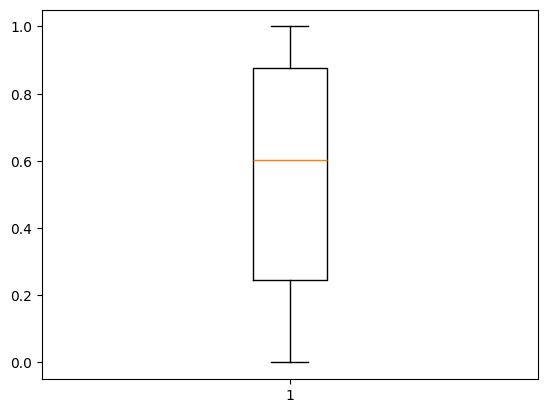

In [ ]:
print(np.quantile(hist, 0.25))
print(np.quantile(hist, 0.75))
plt.boxplot(hist)
plt.show

(array([1.06508876, 0.73594675, 0.69156805, 0.85798817, 1.64940828]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

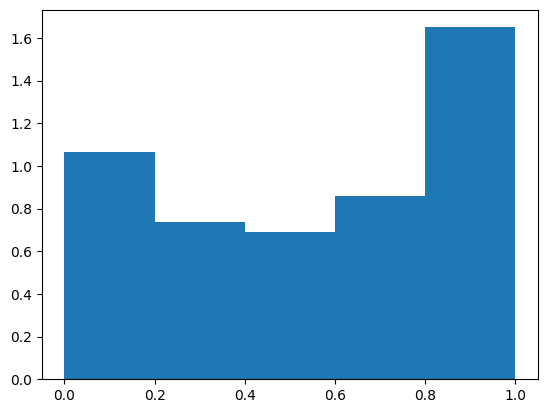

In [ ]:
plt.hist(hist, density=True, bins = 5)

61.86224489795919


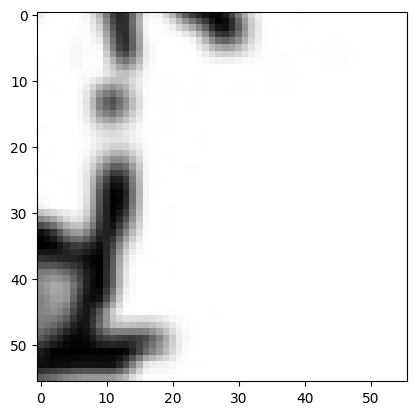

In [ ]:
n += 1
print(100*(np.sum(data["all_tiles"][ind][n] == 255)/(56*56*3)))
plt.imshow(data["all_tiles"][ind][n])

In [ ]:
lw_ind = np.where(np.array([np.sum(x == 255)/(56*56*3) for x in data["all_tiles"]]) <=0.75)[0]
print(lw_ind.shape)

(1884,)


In [ ]:
n=0

1
74.39413265306123


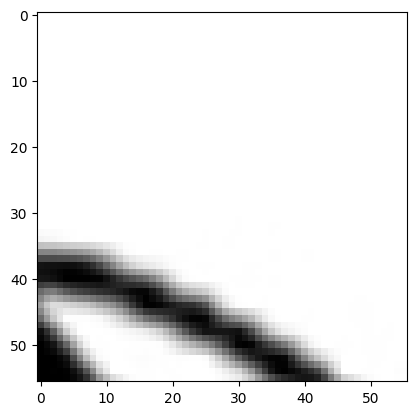

In [ ]:
n += 1
print(n)
print(100*(np.sum(data["all_tiles"][lw_ind][n] == 255)/(56*56*3)))
plt.imshow(data["all_tiles"][lw_ind][n])

In [ ]:
data["tile_images"].shape

(3232, 56, 56, 3)

In [ ]:
unique, counts = np.unique(data["tile_cluster"], return_counts=True)
counts

array([ 240, 1824,  152,   93,   80,   60,  231,  115,  163,   66,   93,
        115])

In [ ]:
unique, counts = np.unique(data["tile_cluster"][lw_ind], return_counts=True)
counts

array([220, 532, 152,  93,  80,  60, 214, 113, 146,  66,  93, 115])

## Pre-Calculate path distances

In [19]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [157]:
data["all_tiles"] = torch.Tensor(data["all_tiles"]/255)
data["all_tiles"] = data["all_tiles"].to("cuda:7")

In [159]:
data["all_tiles"].shape

torch.Size([1039, 56, 56, 3])

In [23]:
dist = VGGPerceptualLoss().to(DEVICE)

/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paulraae/.conda/envs/ms_thesis_Env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [88]:
l = dist(train_tiles[0].reshape(1,3,56,56), train_tiles[10].reshape(1,3,56,56))

In [90]:
l.backward()

In [ ]:
print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(train_img_ind.shape)
print(test_img_ind.shape)

torch.Size([773, 56, 56, 3])
torch.Size([266, 56, 56, 3])
torch.Size([773])
torch.Size([266])
torch.Size([773])
torch.Size([266])


In [24]:
train_tiles = train_tiles.to(DEVICE)
test_tiles = test_tiles.to(DEVICE)

In [28]:
per_distances = []
euc_distances = []
N_SHOTS = 2
i = 0
with torch.no_grad():
    for avg in tqdm(test_tiles):
        i += 1
        per_aux = []
        euc_aux = []
        for img in tqdm(test_tiles[i:]):
            per_aux.append(dist(avg.reshape(1,3,56,56), img.reshape(1,3,56,56), feature_layers=[0, 1, 2, 3]))
            euc_aux.append(torch.dist(avg, img))
        
        per_aux = torch.Tensor(per_aux)
        per_distances.append(per_aux)
        
        euc_aux = torch.Tensor(euc_aux)
        euc_distances.append(euc_aux)
        
        del per_aux, euc_aux
        

    #distances = torch.Tensor(distances)
    

100%|██████████| 1/1 [00:00<00:00, 187.21it/s]
0it [00:00, ?it/s]
100%|██████████| 266/266 [03:00<00:00,  1.48it/s]


In [29]:
patch_distances = {"perception_distances":per_distances, "euclidean_distances":euc_distances}
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_patch_distances.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_patch_distances_backup.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
print(len(per_distances))
print(len(euc_distances))

1041
1041


In [23]:
print(per_distances[1039])

tensor([7.6398])


In [46]:
#
"""
the following python list is populated by tensors that represent the upper triangle of a distance matrix (position 0,300 is the distance between nodes 0 and 300 but 300,0 does not exist as that would be part of the lower triangle). This means that each tensor in the array is of a different length (each succesive tensor is 1 value smaller as that distance value is captured in the tensors above it), which means the full array cannot be converted to a torch tensor. Write a code that fills out the matrix with all distances both upper and lower triangles (both 0,300 and 300,0 should have the same value ie the distance between nodes 0 and 300). Diagonals should be 0 as these would be the distances between a node and itself. When appending a row, the difference in length of each tensor must be fixed before appending into the full matrix. The array's name is - patch_distances["perception_distances"]



do not include comments, code explanations etc only just the code that does the function required

This error coming up due to not fixing the tensor length, that is, not making up for the distances covered in the above tensors for 1 tensor



---------------------------------------------------------------------------RuntimeError Traceback (most recent call last)Cell In[72], line 6 3 full_matrix = torch.zeros((num_nodes, num_nodes), device=data_list[0].device, dtype=data_list[0].dtype) 5 for i, row_data in enumerate(data_list):----> 6 full_matrix[i, i+1:] = row_data 7 full_matrix[i+1:, i] = row_dataRuntimeError: The expanded size of the tensor (1039) must match the existing size (1038) at non-singleton dimension 0. Target sizes: [1039]. Tensor sizes: [1038]
"""

data_list = patch_distances["test"]["perception_distances"]
num_nodes = len(data_list[0]) + 1
full_matrix_per = torch.zeros((num_nodes, num_nodes), device=data_list[0].device, dtype=data_list[0].dtype)

for i, row_data in enumerate(data_list):
    n = row_data.size(0)
    full_matrix_per[i, num_nodes-n:] = row_data
    full_matrix_per[num_nodes-n:, i] = row_data

In [47]:
data_list = patch_distances["test"]["euclidean_distances"]
num_nodes = len(data_list[0]) + 1
full_matrix_euc = torch.zeros((num_nodes, num_nodes), device=data_list[0].device, dtype=data_list[0].dtype)

for i, row_data in enumerate(data_list):
    n = row_data.size(0)
    full_matrix_euc[i, num_nodes-n:] = row_data
    full_matrix_euc[num_nodes-n:, i] = row_data

In [48]:
torch.equal(full_matrix_euc, full_matrix_euc.T)

True

In [49]:
full_matrix_per.shape

torch.Size([266, 266])

In [50]:
patch_distances = {"perception_distances":full_matrix_per, "euclidean_distances":full_matrix_euc}
with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_patch_distances.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/home/paulraae/MS_Thesis_Data/tester_eye_data/test_patch_distances_backup.pk1', 'wb') as handle:
    pickle.dump(patch_distances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
del dist

## Dist Testing

100%|██████████| 93/93 [00:00<00:00, 193.57it/s]


[ 29 923  77]


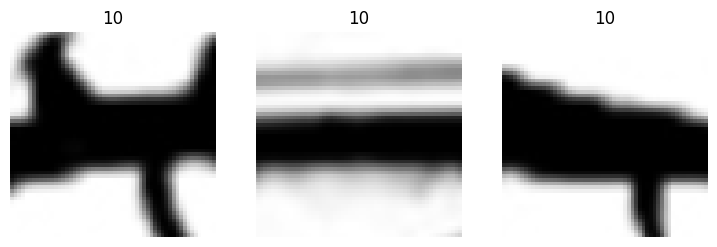

In [40]:
distances = []
N_SHOTS = 2
i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    search_cluster = data["tile_cluster"][i]
    cluster_space = np.where(data["tile_cluster"] == search_cluster)[0]
    for img in tqdm(data["all_tiles"][cluster_space]):
        distances.append(dist(avg.reshape(1,3,56,56), img.reshape(1,3,56,56), feature_layers=[0, 1, 2, 3]))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(cluster_space[indices])
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][cluster_space[indices][1]].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][cluster_space[indices][1]]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][cluster_space[indices][2]].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][cluster_space[indices][2]]))
axes[2].axis('off')
plt.show()
    

100%|██████████| 1041/1041 [00:05<00:00, 200.67it/s]


tensor([ 27, 753, 474])


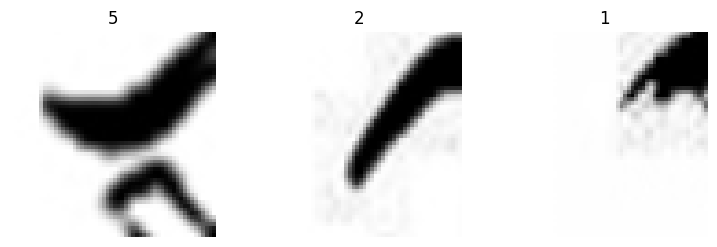

In [36]:
distances = []
N_SHOTS = 2
#i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    for img in tqdm(data["all_tiles"]):
        distances.append(dist(avg.reshape(1,3,56,56), img.reshape(1,3,56,56), feature_layers=[0, 1]))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(indices)
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][indices][1].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][indices][1]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][indices][2].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][indices][2]))
axes[2].axis('off')
plt.show()

[ 27 718 946]


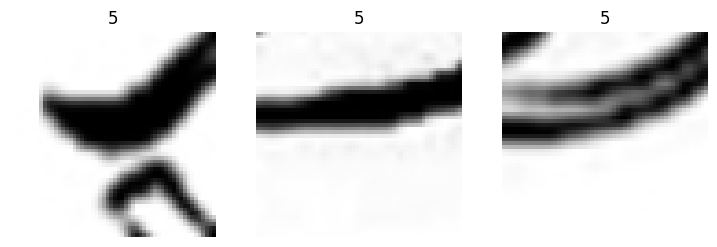

In [37]:
distances = []
N_SHOTS = 2
#i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    search_cluster = data["tile_cluster"][i]
    cluster_space = np.where(data["tile_cluster"] == search_cluster)[0]
    for img in data["all_tiles"][cluster_space]:
        distances.append(torch.dist(avg, img))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(cluster_space[indices])
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][cluster_space[indices][1]].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][cluster_space[indices][1]]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][cluster_space[indices][2]].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][cluster_space[indices][2]]))
axes[2].axis('off')
plt.show()
    

tensor([  27,  753, 1028])


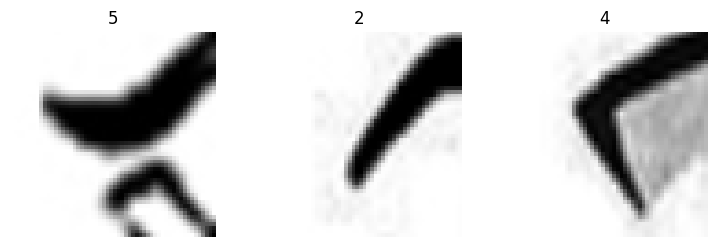

In [38]:
distances = []
N_SHOTS = 2
#i += 1
with torch.no_grad():
    avg = data["all_tiles"][i]
    for img in data["all_tiles"]:
        distances.append(torch.dist(avg, img))
        

    distances = torch.Tensor(distances)
    values, indices = torch.topk(distances, N_SHOTS+1, largest=False, sorted=True)
    
print(indices)
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

axes[0].imshow(data["all_tiles"][i].cpu().detach().numpy())
axes[0].set_title(str(data["tile_cluster"][i]))
axes[0].axis('off')

axes[1].imshow(data["all_tiles"][indices][1].cpu().detach().numpy())
axes[1].set_title(str(data["tile_cluster"][indices][1]))
axes[1].axis('off')

axes[2].imshow(data["all_tiles"][indices][2].cpu().detach().numpy())
axes[2].set_title(str(data["tile_cluster"][indices][2]))
axes[2].axis('off')
plt.show()

## Data Separation

In [8]:
print(lw_ind.shape)
print(pos_ind.shape)
print(img_ind.shape)
print(data["tile_cluster"].shape)
print(data["all_tiles"].shape)

(1039,)
torch.Size([1039])
torch.Size([1039])
(1039,)
(1039, 56, 56, 3)


In [9]:
train_images = torch.Tensor(data['image']).to(torch.float32)
train_images = (train_images - torch.min(train_images))/(torch.max(train_images) - torch.min(train_images))
train_tiles = torch.Tensor(data['all_tiles']).to(torch.float32)
train_tiles = (train_tiles - torch.min(train_tiles))/(torch.max(train_tiles) - torch.min(train_tiles))

train_tiles_clusters = torch.Tensor(data['tile_cluster']).to(torch.int)

In [10]:
unique, counts = np.unique(train_tiles_clusters, return_counts=True)
print(counts)

[103 131 146  73  74  58  73  66  42  66  93 114]


In [ ]:
print(train_tiles.shape)
print(train_tiles_clusters.shape)
print(img_ind.shape)

torch.Size([1039, 56, 56, 3])
torch.Size([1039])
torch.Size([1039])


In [12]:
train_counts=np.array(np.floor(counts*0.75), dtype=np.int64)
print(train_counts)
print(train_counts.sum())
print(counts - train_counts)
print((counts - train_counts).sum())
print((train_counts+(counts-train_counts)) == counts)

[ 77  98 109  54  55  43  54  49  31  49  69  85]
773
[26 33 37 19 19 15 19 17 11 17 24 29]
266
[ True  True  True  True  True  True  True  True  True  True  True  True]


In [13]:
rng = np.random.default_rng()
test_ind = []
train_ind = []
unique, counts = np.unique(train_tiles_clusters, return_counts=True)

for cluster, count in zip(np.unique(train_tiles_clusters), train_counts):
    main_array = np.where(train_tiles_clusters == cluster)[0]
    train_values = rng.choice(main_array, size=count, replace=False)
    test_values = np.setdiff1d(main_array, train_values)
    
    train_ind.extend(train_values)
    test_ind.extend(test_values)

train_ind = np.array(train_ind)
test_ind = np.array(test_ind)
    

In [14]:
print(train_ind.shape)
print(test_ind.shape)

(773,)
(266,)


In [ ]:
test_tiles = train_tiles[test_ind]
train_tiles = train_tiles[train_ind]

train_cluster = train_tiles_clusters[train_ind]
test_cluster = train_tiles_clusters[test_ind]

train_img_ind = img_ind[train_ind]
test_img_ind = img_ind[test_ind]

In [16]:
print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(train_img_ind.shape)
print(test_img_ind.shape)

torch.Size([773, 56, 56, 3])
torch.Size([266, 56, 56, 3])
torch.Size([773])
torch.Size([266])
torch.Size([773])
torch.Size([266])


In [17]:
unique, counts = np.unique(train_cluster, return_counts=True)
print(counts)
print(unique)

[ 77  98 109  54  55  43  54  49  31  49  69  85]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [18]:
unique, counts = np.unique(test_cluster, return_counts=True)
print(counts)
print(unique)

[26 33 37 19 19 15 19 17 11 17 24 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


## Save Data

In [ ]:
print(train_tiles.shape)
print(test_tiles.shape)
print(train_cluster.shape)
print(test_cluster.shape)
print(train_img_ind.shape)
print(test_img_ind.shape)

In [20]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/split_eye_data_dict.pickle"
data = {"train_tiles":train_tiles, "test_tiles":test_tiles, "train_cluster":train_cluster, "test_cluster":test_cluster, "train_img_ind":train_img_ind, "test_img_ind":test_img_ind}
with open('split_eye_tile_dataset.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Model Training

In [4]:
NUM_SAMPLES_PER_GRAPH = 100
NUM_LINES = 4
NUM_NEIGHBORS = 5
NUM_BLOCK_LOOPS = 2
NUM_BLOCKS_PER_HEAD = 2
EDGE_METHOD = "KNN"
DELETION_THRESHOLD = 0.5
GET_BASE_TILES = True
N_SHOTS = 2
DEVICE = "cuda:4" if torch.cuda.is_available() else "cpu"
ATTENTION_HEADS = 4
ACTIVATION_TYPE = "relu"

EPOCHS = 200
LR = 0.0001
D_LR = 0.0001
BATCH_SIZE = 100
K = 5
KP = 5
REAL_LABEL = 1
FAKE_LABEL = 0
SWITCH_THRESHOLD = -1

NUM_GRAPH_NODES = 600

GAN_FREQ = 1
GAN_DISC_FREQ = 50

In [5]:
DEVICE

'cuda:4'

# Gen Only model (Stage 3)

## Model Codes

In [6]:
class Stem(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//8, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//8),
            nn.ReLU(),
            
            nn.Conv2d(out_dim//8, out_dim//4, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//4),
            nn.ReLU(),
            
            nn.Conv2d(out_dim//4, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            nn.ReLU(),
            
            nn.Conv2d(out_dim//2, out_dim, 3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.convs(x)
        return x

In [7]:
class GrapherSetEdges(nn.Module):
    def __init__(self, in_channels, img_dim, at_heads = 4, drop_path=0.0, device = "cuda:7"):
        super(GrapherSetEdges, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = gnn.GATv2Conv(in_channels*img_dim*img_dim, in_channels*img_dim*img_dim, heads = at_heads)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * at_heads, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.device = device

    def forward(self, x, edge_index):
        _tmp = x
        B,C,H,W = x.shape
        x = self.fc1(x)
        x = x.reshape(B,-1)
        x = self.graph_conv(x, edge_index)
        x = x.reshape(B,-1,H,W)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [8]:
class FFN(nn.Module):
    def __init__(self, in_features, act='relu', drop_path=0.0):
        super().__init__()
        out_features = in_features
        hidden_features = in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x


In [9]:
class GraphEncoderBlockSE(nn.Module):
    def __init__(self, in_channels = 3, img_dim = 56, at_heads = 4, drop_path=0.0, device = "cuda:7"):
        super(GraphEncoderBlockSE, self).__init__()
        self.grapher = GrapherSetEdges(in_channels, img_dim, at_heads, drop_path, device)
        self.ffn = FFN(in_channels, drop_path=drop_path)
        self.relu = nn.ReLU(True)


    def forward(self, x, edge_index):
        x = self.grapher(x, edge_index)
        x = self.relu(x)
        return self.ffn(x)

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels = 128, out_channels = 3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels//2, 4, 2, 1),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels//2, in_channels//4, 4, 2, 1),
            nn.BatchNorm2d(in_channels//4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels//4, in_channels//8, 4, 2, 1),
            nn.BatchNorm2d(in_channels//8),
            nn.ReLU(True),
            
            nn.Conv2d(in_channels//8, out_channels, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
class GraphGANWithNoise(nn.Module):
    def __init__(self, in_channels, out_channels, img_dim, at_heads = 4, num_shots = 2, drop_path=0.0, device = "cuda:7"):
        super(GraphGANWithNoise, self).__init__()
        self.stem = Stem(in_channels, out_channels)
        self.graph_model1 = GraphEncoderBlockSE(out_channels, img_dim, at_heads, drop_path, device)
        self.graph_model2 = GraphEncoderBlockSE(out_channels, img_dim, at_heads, drop_path, device)
        #self.inject_noise = InjectNoise(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x, edge_index):
        x = self.stem(x)
        x = self.graph_model1(x, edge_index)
        x = self.relu(x)
        x = self.graph_model2(x, edge_index)
        return self.relu(x)

In [12]:
class FullModel(nn.Module):
    def __init__(self, in_channels, out_channels, img_dim, at_heads = 4, device = "cuda:7"):
        super(FullModel, self).__init__()
        self.e_model = GraphGANWithNoise(in_channels, out_channels, img_dim, at_heads, device = device)
        self.g_model = Generator(out_channels, in_channels)
        
    def forward(self, x, edge_index):
        x = self.e_model(x, edge_index)
        #print(x.shape)
        x = self.g_model(x)
        #print(x.shape)
        return x

## Model  GUNET

In [6]:
class Stem(nn.Module):
    def __init__(self, in_dim=3, out_dim=128):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, out_dim//8, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//8),
            nn.ReLU(),
            
            nn.Conv2d(out_dim//8, out_dim//4, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//4),
            nn.ReLU(),
            
            nn.Conv2d(out_dim//4, out_dim//2, 3, stride=2, padding=1),
            nn.BatchNorm2d(out_dim//2),
            nn.ReLU(),
            
            nn.Conv2d(out_dim//2, out_dim, 3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.convs(x)
        return x

In [7]:
class GrapherSetEdges(nn.Module):
    def __init__(self, in_channels, img_dim, at_heads = 4, drop_path=0.0, device = "cuda:7"):
        super(GrapherSetEdges, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.graph_conv = gnn.GATv2Conv(in_channels*img_dim*img_dim, in_channels*img_dim*img_dim, heads = at_heads)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.fc2 = nn.Sequential(
            nn.Conv2d(in_channels * at_heads, in_channels, 1, stride=1, padding=0),
            nn.BatchNorm2d(in_channels),
        )
        self.device = device

    def forward(self, x, edge_index):
        _tmp = x
        B,C,H,W = x.shape
        x = self.fc1(x)
        x = x.reshape(B,-1)
        x = self.graph_conv(x, edge_index)
        x = x.reshape(B,-1,H,W)
        x = self.fc2(x)
        x = self.drop_path(x) + _tmp
        return x

In [8]:
class FFN(nn.Module):
    def __init__(self, in_features, act='relu', drop_path=0.0):
        super().__init__()
        out_features = in_features
        hidden_features = in_features
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_features, hidden_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(hidden_features),
        )
        self.act = act_layer(act)
        self.fc2 = nn.Sequential(
            nn.Conv2d(hidden_features, out_features, 1, stride=1, padding=0),
            nn.BatchNorm2d(out_features),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        shortcut = x
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.drop_path(x) + shortcut
        return x


In [9]:
class GraphEncoderBlockSE(nn.Module):
    def __init__(self, in_channels = 3, img_dim = 56, at_heads = 4, drop_path=0.0, device = "cuda:7"):
        super(GraphEncoderBlockSE, self).__init__()
        self.grapher = GrapherSetEdges(in_channels, img_dim, at_heads, drop_path, device)
        self.ffn = FFN(in_channels, drop_path=drop_path)
        self.relu = nn.ReLU(True)


    def forward(self, x, edge_index):
        x = self.grapher(x, edge_index)
        x = self.relu(x)
        return self.ffn(x)

In [10]:
class Generator(nn.Module):
    def __init__(self, in_channels = 128, out_channels = 3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
class GraphGANWithNoise(nn.Module):
    def __init__(self, in_channels, out_channels, img_dim, at_heads = 4, num_shots = 2, drop_path=0.0, device = "cuda:7"):
        super(GraphGANWithNoise, self).__init__()
        self.graph_model1 = GraphEncoderBlockSE(out_channels, img_dim, at_heads, drop_path, device)
        #self.graph_model2 = GraphEncoderBlockSE(out_channels, img_dim, at_heads, drop_path, device)
        #self.inject_noise = InjectNoise(out_channels)
        self.relu = nn.ReLU(True)

    def forward(self, x, edge_index):
        x = self.graph_model1(x, edge_index)
        x = self.relu(x)
        #x = self.graph_model2(x, edge_index)
        return x

In [51]:
class FullModel(nn.Module):
    def __init__(self, in_channels, out_channels, img_dim, at_heads = 4, device = "cuda:7"):
        super(FullModel, self).__init__()
        self.stem = Stem(in_channels, out_channels)
        self.e_model1 = GraphGANWithNoise(out_channels, out_channels, img_dim, at_heads, device = device)
        self.g_model1 = Generator(out_channels, out_channels//2)
        self.e_model2 = GraphGANWithNoise(out_channels//2, out_channels//2, img_dim*2, at_heads, device = device)
        self.g_model2 = Generator(out_channels//2, out_channels//4)
        self.g_model3 = Generator(out_channels//4, out_channels//8)
        self.out = nn.Sequential(
            nn.Conv2d(out_channels//8, in_channels, 3, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, edge_index):
        x = self.stem(x)
        x = self.e_model1(x, edge_index)
        x = self.g_model1(x)
        x = self.e_model2(x, edge_index)
        x = self.g_model2(x)
        x = self.g_model3(x)
        x = self.out(x)
        return x

## Testing

In [53]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)
    train_index = train_index[:700].reshape(-1, BATCH_SIZE)
    for tr_ind in train_index:
        
        out = torch.topk(patch_distances["train"]["perception_distances"][tr_ind], K+1, largest=False).indices
        batch = train_tiles[out]
        pred = []
        for input in batch:
            break
        break
    break

In [ ]:
tr_ind[:3]

In [25]:
input = train_tiles[[700,370,189, 69]]

In [22]:
input = test_tiles[[213,24,69, 124]]

### Save Models

In [ ]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/plus_pcl_continue_train.pickle"
torch.save(model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/plus_pcl_continue_train_backup.pickle"
torch.save(model.state_dict(), SAVE_PATH)

### Testing

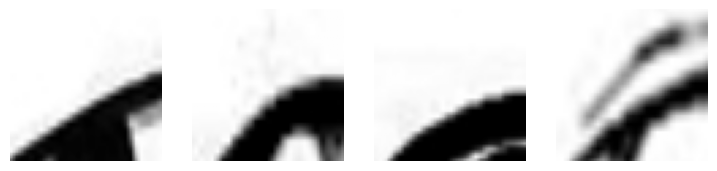

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(9, 3))

axes[0].imshow(input[0].cpu())
axes[0].axis('off')

axes[1].imshow(input[1].cpu())
axes[1].axis('off')

axes[2].imshow(input[2].cpu())
axes[2].axis('off')

axes[3].imshow(input[3].cpu())
axes[3].axis('off')
plt.show()

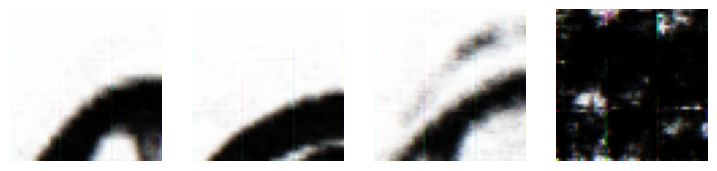

In [55]:
model.eval()
edge_index = torch.Tensor([[0,0,0,1,1],[1,2,3,2,3]]).to(torch.int).to(DEVICE)
with torch.no_grad():
    noise = torch.randn(1, 3, 56, 56, device=DEVICE)
    input = input[:4].reshape(4,3,56,56).to(DEVICE)
    input[0] = noise
    pred = model(input, edge_index)
    del input
    
fig, axes = plt.subplots(1, 4, figsize=(9, 3))

axes[0].imshow(pred[1].cpu().reshape(56,56,3))
axes[0].axis('off')

axes[1].imshow(pred[2].cpu().reshape(56,56,3))
axes[1].axis('off')

axes[2].imshow(pred[3].cpu().reshape(56,56,3))
axes[2].axis('off')

axes[3].imshow(pred[0].cpu().reshape(56,56,3))
axes[3].axis('off')
plt.show()

In [53]:
print(pred[0].shape)
print(input[2].reshape(3,56,56).shape)

torch.Size([3, 56, 56])
torch.Size([3, 56, 56])


In [116]:
p_loss(pred[0].unsqueeze(0), input[0].reshape(1,3,56,56).to(DEVICE), [0, 3], [4])

tensor(1.9952, device='cuda:0')

In [38]:
tr_ind = tr_ind.T.copy() 
tr_ind = torch.from_numpy(tr_ind).to(DEVICE)

In [44]:
train_tiles[tr_ind].reshape(K+1, BATCH_SIZE, 3, 56, 56).shape

torch.Size([3, 100, 3, 56, 56])

In [42]:
loss(pred, train_tiles[tr_ind].reshape(K+1, BATCH_SIZE, 3, 56, 56))

tensor(1.0516, device='cuda:7', grad_fn=<DivBackward0>)

## Training Loop

In [13]:
#edge_index = torch.Tensor([[0,0,0,1,1],[1,2,3,2,3]]).to(torch.int).to(DEVICE)
model = FullModel(3, 128, 7, 4, device = DEVICE)
model = model.to(DEVICE)
best = [0, np.Inf]

In [ ]:
#SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/plus_pcl_continue_train.pickle"
#model.load_state_dict(torch.load(SAVE_PATH, weights_only=True))

<All keys matched successfully>

In [14]:
LR = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [15]:
#p_loss = VGGPerceptualLoss().to(DEVICE)
loss = nn.MSELoss()

In [16]:
def generate_random_edges(k):
    nodes = np.arange(1, k + 1)
    np.random.shuffle(nodes)
    
    initial_edges = []
    for i in range(0, k - 1, 2):
        if i + 1 < k:
            initial_edges.append(sorted([nodes[i], nodes[i+1]]))
    
    if k % 2 != 0:
        extra_conn = np.random.choice(nodes[:-1])
        initial_edges.append(sorted([nodes[-1], extra_conn]))

    possible_edges = []
    for i in range(1, k + 1):
        for j in range(i + 1, k + 1):
            edge = [i, j]
            if edge not in initial_edges:
                possible_edges.append(edge)
    
    max_extra = len(possible_edges)
    n_extra = np.random.randint(0, max_extra + 1) if max_extra > 0 else 0
    
    if n_extra > 0:
        idx = np.random.choice(len(possible_edges), n_extra, replace=False)
        extra_edges = [possible_edges[i] for i in idx]
        all_edges = initial_edges + extra_edges
    else:
        all_edges = initial_edges

    edge_array = np.array(all_edges)
    return [edge_array[:, 0].tolist(), edge_array[:, 1].tolist()]

In [17]:
import copy

def randomize_batch(x, tiles, device="cuda:1"):
    b, k = x.shape
    _, h, w, c = tiles.shape
    noise = torch.randn(b ,1, c, h, w, device=device)
    noise = (noise - noise.min())/(noise.max()-noise.min())
    
    batch = []
    targets = []
    
    i=-1
    for ind in x:
        i+=1
        ind = ind.detach().cpu().numpy()
        np.random.shuffle(ind)
        ind = torch.Tensor(ind[:np.random.randint(3, k+1)]).to(torch.long)
        k1 = ind.shape[-1]
        aux = tiles[ind].reshape(k1, c, h, w).to(device)
        targets.append(copy.deepcopy(aux))
        aux[0] = noise[i]
        batch.append(aux)
        del aux
    
    del noise
    return batch, targets

def randomize_edge_index(k, device="cuda:1"):
    edge_index = [[i+1 for i in range(k-1)], [0 for _ in range(k-1)]]
    i=-1
    for x in generate_random_edges(k-1):
        i+=1
        edge_index[i] = edge_index[i] + x
    return torch.Tensor(edge_index).to(torch.long).to(device)
    

In [39]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    
    running_mse_loss = 0.0
    #running_tot_loss = 0.0
    
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)

    train_index = train_index.T[:700].reshape(-1,BATCH_SIZE)
    i=-1
    
    for tr_ind in tqdm(train_index):
        torch.cuda.empty_cache()
        i+=1
        tr_ind = torch.topk(patch_distances["train"]["perception_distances"][tr_ind], K+1, largest=False).indices
        batch, targets = randomize_batch(tr_ind, train_tiles, DEVICE)
        pred = []
        
        pcl = 0
        for input, y in zip(batch, targets):
            k = input.shape[0]
            edge_index = randomize_edge_index(k, DEVICE)
        
            aux = model(input, edge_index)
            pcl += loss(aux.reshape(-1, 3, 56, 56), y.reshape(-1, 3, 56, 56))
            #pred.append(aux)
            #del aux, input, edge_index, y
        #del batch
        pcl = pcl/BATCH_SIZE
        running_mse_loss += pcl.item()
        
        optimizer.zero_grad()
        pcl.backward()
        optimizer.step()
        
        del pcl
        
    print("MSE Loss", running_mse_loss/i)

Epoch: 0


100%|██████████| 7/7 [00:39<00:00,  5.68s/it]


MSE Loss 0.03044191189110279
Epoch: 1


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.025838975173731644
Epoch: 2


100%|██████████| 7/7 [00:42<00:00,  6.03s/it]


MSE Loss 0.024120900469521683
Epoch: 3


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.02393291766444842
Epoch: 4


100%|██████████| 7/7 [00:39<00:00,  5.68s/it]


MSE Loss 0.023710503553350765
Epoch: 5


100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


MSE Loss 0.022732004212836426
Epoch: 6


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.021349121971676748
Epoch: 7


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.021394132636487484
Epoch: 8


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.022100872360169888
Epoch: 9


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


MSE Loss 0.021759044689436752
Epoch: 10


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.020939321722835302
Epoch: 11


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.020905047189444304
Epoch: 12


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.02214459826548894
Epoch: 13


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01990417701502641
Epoch: 14


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.02040687793244918
Epoch: 15


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.02041518936554591
Epoch: 16


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.02092471858486533
Epoch: 17


100%|██████████| 7/7 [00:40<00:00,  5.73s/it]


MSE Loss 0.021893287387986977
Epoch: 18


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.02067729675521453
Epoch: 19


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.019242417222509783
Epoch: 20


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


MSE Loss 0.019224617009361584
Epoch: 21


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.021534623422970373
Epoch: 22


100%|██████████| 7/7 [00:41<00:00,  5.88s/it]


MSE Loss 0.019552477169781923
Epoch: 23


100%|██████████| 7/7 [00:41<00:00,  5.86s/it]


MSE Loss 0.01975547211865584
Epoch: 24


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.02031618356704712
Epoch: 25


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.019132214443137247
Epoch: 26


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.019726394520451624
Epoch: 27


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.019469620970388252
Epoch: 28


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01878793320308129
Epoch: 29


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.017904891166836023
Epoch: 30


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01943696103990078
Epoch: 31


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.018859096337109804
Epoch: 32


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.018239551999916632
Epoch: 33


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.018851122818887234
Epoch: 34


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


MSE Loss 0.017977528429279726
Epoch: 35


100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


MSE Loss 0.018104881203422945
Epoch: 36


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.017640506227811176
Epoch: 37


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01870916271582246
Epoch: 38


100%|██████████| 7/7 [00:41<00:00,  5.89s/it]


MSE Loss 0.018329332893093426
Epoch: 39


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.017411527999987204
Epoch: 40


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.017988155440737803
Epoch: 41


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.018281138657281797
Epoch: 42


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.019467203877866268
Epoch: 43


100%|██████████| 7/7 [00:41<00:00,  5.98s/it]


MSE Loss 0.01815468321243922
Epoch: 44


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.017925788182765245
Epoch: 45


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.017234654786686104
Epoch: 46


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.017430677854766447
Epoch: 47


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01669430546462536
Epoch: 48


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.017341264989227057
Epoch: 49


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.016167265673478443
Epoch: 50


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.017688473065694172
Epoch: 51


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


MSE Loss 0.01776335233201583
Epoch: 52


100%|██████████| 7/7 [00:42<00:00,  6.00s/it]


MSE Loss 0.0170859363861382
Epoch: 53


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01709069140876333
Epoch: 54


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.017821484400580328
Epoch: 55


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


MSE Loss 0.01750609651207924
Epoch: 56


100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


MSE Loss 0.01692363666370511
Epoch: 57


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.017266488323609035
Epoch: 58


100%|██████████| 7/7 [00:39<00:00,  5.68s/it]


MSE Loss 0.017523204286893208
Epoch: 59


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.018779614474624395
Epoch: 60


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01871505177890261
Epoch: 61


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.0168070737272501
Epoch: 62


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016988847715159256
Epoch: 63


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01701780455186963
Epoch: 64


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.017267658685644467
Epoch: 65


100%|██████████| 7/7 [00:41<00:00,  5.99s/it]


MSE Loss 0.016066430912663538
Epoch: 66


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


MSE Loss 0.01750896032899618
Epoch: 67


100%|██████████| 7/7 [00:40<00:00,  5.78s/it]


MSE Loss 0.01691758430873354
Epoch: 68


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.016641066099206608
Epoch: 69


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01640855536485712
Epoch: 70


100%|██████████| 7/7 [00:42<00:00,  6.08s/it]


MSE Loss 0.015538002519557873
Epoch: 71


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016715520682434242
Epoch: 72


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01717486185953021
Epoch: 73


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01692527175570528
Epoch: 74


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.017477053993692
Epoch: 75


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016316860759009916
Epoch: 76


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016783999744802713
Epoch: 77


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01806965625534455
Epoch: 78


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01651574733356635
Epoch: 79


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.017959573927025
Epoch: 80


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01660531743740042
Epoch: 81


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01626102455581228
Epoch: 82


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01758369120458762
Epoch: 83


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016170738264918327
Epoch: 84


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.017397608452787
Epoch: 85


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.017191083480914433
Epoch: 86


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015891585033386946
Epoch: 87


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016565595132609207
Epoch: 88


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016094312071800232
Epoch: 89


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.016033008228987455
Epoch: 90


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01617977535352111
Epoch: 91


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01703830575570464
Epoch: 92


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01689617366840442
Epoch: 93


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.0165684901488324
Epoch: 94


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016066299751400948
Epoch: 95


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016209661805381376
Epoch: 96


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016183204483240843
Epoch: 97


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016946614409486454
Epoch: 98


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01653562889744838
Epoch: 99


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015122577548027039
Epoch: 100


100%|██████████| 7/7 [00:41<00:00,  5.93s/it]


MSE Loss 0.015792591807742912
Epoch: 101


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.017426864554484684
Epoch: 102


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01544384922211369
Epoch: 103


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016641659351686638
Epoch: 104


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.017966274016847212
Epoch: 105


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016590044057617586
Epoch: 106


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016795271697143715
Epoch: 107


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01613917558764418
Epoch: 108


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015922200089941423
Epoch: 109


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01526059303432703
Epoch: 110


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016598244508107502
Epoch: 111


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01678272771338622
Epoch: 112


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.017160351232935984
Epoch: 113


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016687736691286165
Epoch: 114


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.016876797657459974
Epoch: 115


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016330801726629336
Epoch: 116


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016129141828666132
Epoch: 117


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


MSE Loss 0.015493042456607023
Epoch: 118


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015212677574406067
Epoch: 119


100%|██████████| 7/7 [00:39<00:00,  5.69s/it]


MSE Loss 0.01691697460288803
Epoch: 120


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016166050142298143
Epoch: 121


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015457507222890854
Epoch: 122


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015575952517489592
Epoch: 123


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01569289683053891
Epoch: 124


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015536978219946226
Epoch: 125


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.0164782521314919
Epoch: 126


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016696298339714605
Epoch: 127


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.015779702303310234
Epoch: 128


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01606155497332414
Epoch: 129


100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


MSE Loss 0.0160304334325095
Epoch: 130


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015533329142878452
Epoch: 131


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01641016686335206
Epoch: 132


100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


MSE Loss 0.015897728347529966
Epoch: 133


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01591684017330408
Epoch: 134


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.016300929555048544
Epoch: 135


100%|██████████| 7/7 [00:40<00:00,  5.72s/it]


MSE Loss 0.016453389544039965
Epoch: 136


100%|██████████| 7/7 [00:40<00:00,  5.72s/it]


MSE Loss 0.01686493493616581
Epoch: 137


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.016345398190120857
Epoch: 138


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.01546006416901946
Epoch: 139


100%|██████████| 7/7 [00:40<00:00,  5.76s/it]


MSE Loss 0.015578360296785831
Epoch: 140


100%|██████████| 7/7 [00:41<00:00,  5.98s/it]


MSE Loss 0.015528101474046707
Epoch: 141


100%|██████████| 7/7 [00:41<00:00,  5.94s/it]


MSE Loss 0.01598869279647867
Epoch: 142


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01609290748213728
Epoch: 143


100%|██████████| 7/7 [00:40<00:00,  5.74s/it]


MSE Loss 0.01566402909035484
Epoch: 144


100%|██████████| 7/7 [00:40<00:00,  5.74s/it]


MSE Loss 0.01582611771300435
Epoch: 145


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016134994104504585
Epoch: 146


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01525361385817329
Epoch: 147


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.016275983148564894
Epoch: 148


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


MSE Loss 0.015463662333786488
Epoch: 149


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016150037447611492
Epoch: 150


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.016724117876340944
Epoch: 151


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.016114650604625542
Epoch: 152


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.015926440401623648
Epoch: 153


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.01584266560773055
Epoch: 154


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01610326487571001
Epoch: 155


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.01600718420619766
Epoch: 156


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.017217355780303478
Epoch: 157


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.016000118106603622
Epoch: 158


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016058896978696186
Epoch: 159


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015317792383333048
Epoch: 160


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.015495339874178171
Epoch: 161


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01548996257285277
Epoch: 162


100%|██████████| 7/7 [00:39<00:00,  5.68s/it]


MSE Loss 0.015766975625107687
Epoch: 163


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01606935216113925
Epoch: 164


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015246292731414238
Epoch: 165


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.015594795035819212
Epoch: 166


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.01590511326988538
Epoch: 167


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.014639795757830143
Epoch: 168


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.015400897711515427
Epoch: 169


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01547157500560085
Epoch: 170


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.015968396949271362
Epoch: 171


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01543418737128377
Epoch: 172


100%|██████████| 7/7 [00:40<00:00,  5.73s/it]


MSE Loss 0.015576620430996021
Epoch: 173


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.015924701777597267
Epoch: 174


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


MSE Loss 0.016223176537702482
Epoch: 175


100%|██████████| 7/7 [00:40<00:00,  5.79s/it]


MSE Loss 0.015917241883774597
Epoch: 176


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.01587100125228365
Epoch: 177


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.016362146319200594
Epoch: 178


100%|██████████| 7/7 [00:40<00:00,  5.83s/it]


MSE Loss 0.01645384853084882
Epoch: 179


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.015257766004651785
Epoch: 180


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015594697402169308
Epoch: 181


100%|██████████| 7/7 [00:41<00:00,  5.87s/it]


MSE Loss 0.017184661235660315
Epoch: 182


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.0151150346112748
Epoch: 183


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01628112280741334
Epoch: 184


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.015950100651631754
Epoch: 185


100%|██████████| 7/7 [00:39<00:00,  5.64s/it]


MSE Loss 0.016227649835248787
Epoch: 186


100%|██████████| 7/7 [00:39<00:00,  5.70s/it]


MSE Loss 0.01571276302759846
Epoch: 187


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]


MSE Loss 0.01557639908666412
Epoch: 188


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015324396081268787
Epoch: 189


100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


MSE Loss 0.015583361654231945
Epoch: 190


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.01444043560574452
Epoch: 191


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015601158142089844
Epoch: 192


100%|██████████| 7/7 [00:40<00:00,  5.84s/it]


MSE Loss 0.015148333429048458
Epoch: 193


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.015430298944314321
Epoch: 194


100%|██████████| 7/7 [00:39<00:00,  5.65s/it]


MSE Loss 0.015222397012015184
Epoch: 195


100%|██████████| 7/7 [00:39<00:00,  5.67s/it]


MSE Loss 0.015483131011327108
Epoch: 196


100%|██████████| 7/7 [00:40<00:00,  5.75s/it]


MSE Loss 0.015572438792635998
Epoch: 197


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01624053670093417
Epoch: 198


100%|██████████| 7/7 [00:39<00:00,  5.63s/it]


MSE Loss 0.01578440237790346
Epoch: 199


100%|██████████| 7/7 [00:39<00:00,  5.66s/it]

MSE Loss 0.016024752985686064


In [56]:
SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/GUNET3_1.pickle"
torch.save(model.state_dict(), SAVE_PATH)

SAVE_PATH = "/home/paulraae/MS_Thesis/ViG_based_link_pred_implementation/saved_models/GUNET3_1_backup.pickle"
torch.save(model.state_dict(), SAVE_PATH)

In [ ]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    running_loss = 0.0
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)
    train_index = train_index[:700].reshape(-1, BATCH_SIZE)
    i=0
    for tr_ind in tqdm(train_index):
        i+=1
        optimizer.zero_grad()
        
        out = torch.topk(patch_distances["perception_distances"][tr_ind], K+1, largest=False).indices
        batch = train_tiles[out]
        pred = []

        for input in batch:
            aux = model(input.reshape(3,3,56,56), edge_index)
            pred.append(aux)
            del aux, input

        pred = torch.cat(pred, dim=0)
        
        pcl = loss(pred, train_tiles[tr_ind].reshape(-1, 3, 56, 56))
        del pred
        pcl.backward()
        optimizer.step()
        running_loss += pcl.item()
        
    print("Percetion Loss: ",running_loss/BATCH_SIZE)

In [35]:
import torch
import torchvision

class VGGPerceptualLoss(torch.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
        self.blocks = torch.nn.ModuleList(blocks)
        self.transform = torch.nn.functional.interpolate
        self.resize = resize
        self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer("std", torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, input, target, feature_layers=[0, 1, 2, 3], style_layers=[]):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for i, block in enumerate(self.blocks):
            x = block(x)
            y = block(y)
            if i in feature_layers:
                loss += torch.nn.functional.l1_loss(x, y)
            if i in style_layers:
                act_x = x.reshape(x.shape[0], x.shape[1], -1)
                act_y = y.reshape(y.shape[0], y.shape[1], -1)
                gram_x = act_x @ act_x.permute(0, 2, 1)
                gram_y = act_y @ act_y.permute(0, 2, 1)
                loss += torch.nn.functional.l1_loss(gram_x, gram_y)
        return loss

In [ ]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    
    running_loss = 0.0
    
    train_index = np.array([[x for x in range(train_tiles.shape[0])] for _ in range(K+1)])
    for tr_ind in train_index:
        np.random.shuffle(tr_ind)

    train_index = train_index.T[:00].reshape(-1,BATCH_SIZE,K+1)
    i=0
    
    for tr_ind in tqdm(train_index):
        
        i+=1
        
        batch = train_tiles[tr_ind]
        pred = []

        for input in batch:
            aux = model(input.reshape(3,3,56,56), edge_index)
            pred.append(aux)
            del aux, input

        pred = torch.cat(pred, dim=0)
        tr_ind = tr_ind.T.copy() 
        tr_ind = torch.from_numpy(tr_ind).to(DEVICE)
        if epoch >= SWITCH_THRESHOLD and epoch%GAN_FREQ == 0.0:

            label = torch.full((BATCH_SIZE,), REAL_LABEL, dtype=torch.float, device=DEVICE)
            for p in d_model.parameters():
                p.requires_grad = True
                
            d_real_pred = d_model(train_tiles[tr_ind][0].reshape(BATCH_SIZE, 3, 56, 56)).view(-1)
            d_real_loss = loss_func(d_real_pred, label)
            drl = d_real_loss.mean().item()
            
            label_fake = torch.full((BATCH_SIZE,), FAKE_LABEL, dtype=torch.float, device=DEVICE)
            d_fake_pred = d_model(pred.detach()).view(-1)
            d_fake_loss = loss_func(d_fake_pred, label_fake)
            dfl = d_fake_loss.mean().item()

            if epoch%GAN_DISC_FREQ == 0.0:
                d_loss = (d_real_loss + d_fake_loss)/2
                d_optimizer.zero_grad()
                d_loss.backward()
                d_optimizer.step()
            
            for p in d_model.parameters():
                p.requires_grad = False
            
            optimizer.zero_grad()
            d_g_pred = d_model(pred).view(-1)
            del pred
            d_g_loss = loss_func(d_g_pred, label)
            dgl = d_g_loss.mean().item()
            
            d_g_loss.backward()
            optimizer.step()
        else:
            pcl  = 0.33*loss(pred, train_tiles[tr_ind][0].reshape(BATCH_SIZE, 3, 56, 56))
            pcl += 0.33*loss(pred, train_tiles[tr_ind][1].reshape(BATCH_SIZE, 3, 56, 56))
            pcl += 0.33*loss(pred, train_tiles[tr_ind][2].reshape(BATCH_SIZE, 3, 56, 56))
            del pred
            pcl.backward()
            running_loss += pcl.item()
            optimizer.step()
        
        
        
    if epoch >= SWITCH_THRESHOLD and epoch%GAN_FREQ == 0.0:
        print("Discrimor:", dfl+drl)
        print("Generator:", dgl)
    else:
        print("PCL Loss", running_loss/BATCH_SIZE)

In [118]:
train_tiles[tr_ind].shape

torch.Size([100, 56, 56, 3])

In [160]:
EPOCHS = 250

In [ ]:
for epoch in range(EPOCHS):
    print("Epoch:",epoch)
    running_loss = 0.0
    train_index = np.array([x for x in range(train_tiles.shape[0])])
    np.random.shuffle(train_index)
    train_index = train_index[:700].reshape(-1, BATCH_SIZE)
    for tr_ind in tqdm(train_index):
        optimizer.zero_grad()
        
        out = torch.topk(patch_distances["perception_distances"][tr_ind], K+1, largest=False).indices
        batch = train_tiles[out]
        pred = []
        
        for input in batch:
            aux = model(input.reshape(3,3,56,56), edge_index)
            pred.append(aux)
            del aux, input

        pred = torch.cat(pred, dim=0)
        out = out.cpu().numpy()
        out = out.T.copy() 
        out = torch.from_numpy(out).to(DEVICE)
        
        pcl = loss(pred[:3], train_tiles[out].reshape(-1, 3, 56, 56))
        del pred
        pcl.backward()
        optimizer.step()
        running_loss += pcl.item()
        
    print("Percetion Loss: ",running_loss/BATCH_SIZE)

In [66]:
train_tiles[out].shape

torch.Size([100, 3, 56, 56, 3])

In [20]:
i=-1

In [47]:
out_euc[0]

tensor(822)

In [ ]:
#i+=1
out_per = torch.topk(patch_distances["perception_distances"][train_index[0]][i], K+1, largest=False).indices[1::]
out_euc = torch.topk(patch_distances["euclidean_distances"][train_index[0]][i], K+1, largest=False).indices[1::]
print(train_index[0][i])
print(out_per)
print(out_euc)
out = torch.cat([out_per,out_euc])

1034
tensor([188, 892])
tensor([822,  83])


tensor([188, 892, 822,  83])

In [40]:
out.shape[0]>3

True

# Gen Model Training Loop (2nd Stage)

In [60]:
del model

In [76]:
model = FullModel(16 ,N_SHOTS, NUM_BLOCK_LOOPS, NUM_BLOCKS_PER_HEAD, 3, 48, 7, 4)
model = model.to(DEVICE)

In [ ]:
d_model = Discriminator(3, 512)
d_model = d_model.to(DEVICE)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr = LR)
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
model = FullModel(16 ,N_SHOTS, NUM_BLOCK_LOOPS, NUM_BLOCKS_PER_HEAD, 3, 48, 7, 4)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr = LR)
loss_func = nn.BCEWithLogitsLoss()
mse_loss_func = nn.MSELoss()

In [79]:
for epoch in range(EPOCHS):
  print(epoch)
  B,T,H,W,C = all_query_tiles.shape
  model.train()
  running_loss = 0.0
  count = 0
  #graph_indeces = np.random.choice(np.array([x for x in range(B)]),
  #                                 size=GRAPH_BATCH_SIZE, replace=False)

  train_indeces = np.random.choice(np.array([x for x in range(B)]),
                                   size=EPOCH_BATCH_SIZE, replace=False)
  train_indeces = train_indeces.reshape(-1, TRAIN_BATCH_SIZE)


  graph_sample = train_tiles.reshape(-1, 3, 56, 56)
  graph_sample = graph_sample.unsqueeze(0).expand(TRAIN_BATCH_SIZE, -1, 3, 56, 56)
  #B,_,H,W,C = graph_sample.shape
  #graph_sample = graph_sample.reshape(B*T,C,H,W)

  for i in train_indeces:
    #query_tiles = all_query_tiles[i].reshape(TRAIN_BATCH_SIZE, T,C,H,W)
    query_img = train_images[i].reshape(TRAIN_BATCH_SIZE, 3,224,224)

    input = graph_sample #torch.cat([query_tiles, graph_sample], dim=1)

    indeces = torch.Tensor([x for x in range(input.shape[0]-16)])
    query_img = query_img.to(DEVICE)
    input = input.to(DEVICE)

    if epoch>SWITCH_THRESHOLD:
      d_optimizer.zero_grad()

      label = torch.full((TRAIN_BATCH_SIZE,), REAL_LABEL, dtype=torch.float, device=DEVICE)
      d_real_pred = d_model(query_img).view(-1)
      d_real_loss = loss_func(d_real_pred, label)
      drl = d_real_loss.mean().item()

    pred = []

    for j in tqdm(input):
      aux = model(query_img, j, T, NUM_NEIGHBORS, EDGE_METHOD)
      pred.append(aux)
      del aux

    pred = torch.cat(pred, dim=0)

    if epoch > SWITCH_THRESHOLD:

      label_fake = torch.full((TRAIN_BATCH_SIZE,), FAKE_LABEL, dtype=torch.float, device=DEVICE)
      d_fake_pred = d_model(pred.detach()).view(-1)
      d_fake_loss = loss_func(d_fake_pred,label_fake)
      dfl = d_fake_loss.mean().item()

      d_loss = (d_real_loss + d_fake_loss)/2
      d_loss.backward()
      d_optimizer.step()

      optimizer.zero_grad()
      d_g_pred = d_model(pred).view(-1)
      d_g_loss = loss_func(d_g_pred, label)
      dgl = d_g_loss.mean().item()

    #g_mse_loss = mse_loss_func(pred, query_img)
    #gml = g_mse_loss.mean().item()

    if epoch > SWITCH_THRESHOLD:

      #g_loss = d_g_loss# + g_mse_loss*0.75
      #g_loss.backward()
      d_g_loss.backward()
      optimizer.step()
      print("Discrimor:", dfl+drl)
      print("Generator:", dgl)
      #print("Generator MSE:", gml)

    else:
      #g_mse_loss.backward()
      optimizer.step()
      #print("Generator:", gml)

0


 50%|█████     | 10/20 [00:18<00:18,  1.84s/it]


KeyboardInterrupt: 

In [ ]:
pred.dtype

torch.float32

In [71]:
i = 25
B,T,H,W,C = all_query_tiles.shape
query_tiles = all_query_tiles[i].reshape(T,C,H,W)
query_img = train_images[i].reshape(1,3,224,224)
mask = torch.arange(train_images.shape[0]) != i
graph_sample = train_tiles.reshape(-1, 3, 56, 56)
input = torch.cat([query_tiles, graph_sample], dim=0)

indeces = torch.Tensor([x for x in range(input.shape[0]-16)])
query_img = query_img.to(DEVICE)
input = input.to(DEVICE)

In [72]:
print(query_img.shape)
print(input.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1900, 3, 56, 56])


In [73]:
with torch.no_grad():
  out = model(query_img, input, T, NUM_NEIGHBORS, EDGE_METHOD)

In [35]:
out.shape

torch.Size([1, 3, 224, 224])

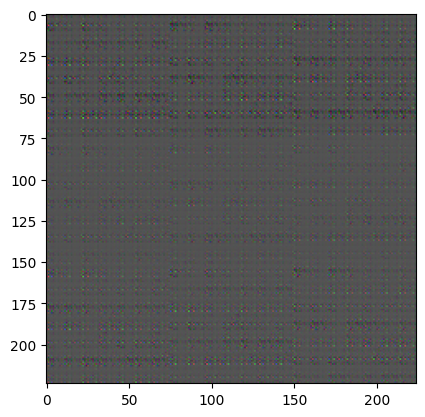

In [74]:
plt.imshow(out.reshape(224,224,3).detach().cpu().numpy())
plt.show()

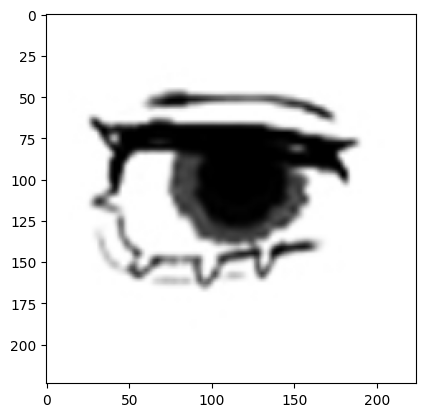

In [37]:
plt.imshow(query_img.reshape(224,224,3).detach().cpu().numpy())
plt.show()

In [ ]:
for i in range(train_images.shape[0]):
  with torch.no_grad():
    B,T,H,W,C = train_tiles.shape
    query_img = train_tiles[i].reshape(T,C,H,W)
    mask = torch.arange(train_images.shape[0]) != i
    graph_sample = train_tiles[np.random.choice(train_index[mask], NUM_SAMPLES_PER_GRAPH, replace=False)]
    B,_,H,W,C = graph_sample.shape
    graph_sample = graph_sample.reshape(B*T,C,H,W)
    input = torch.cat([query_img, graph_sample], dim=0)
    indeces = torch.Tensor([x for x in range(input.shape[0]-16)])

  #Insert Stem Model to get embeddings

  for loop in range(NUM_BLOCK_LOOPS):
    input = model(input, T, NUM_NEIGHBORS, EDGE_METHOD)

    with torch.no_grad():
      input, t_indeces = get_past_threshold(input, T, DELETION_THRESHOLD)
      indeces = indeces[t_indeces]

  n_shot_indices = []
  with torch.no_grad():
    full_set, shot_set, remaining_indeces, shot_indices = get_multi_shot_set(input, T, N_SHOTS)
    for shot in shot_indices:
      n_shot_indices.append(indeces[shot])
    n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)
    indeces = indeces[remaining_indeces]


  #Insert Generative Model


  break


NameError: name 'train_images' is not defined

In [ ]:
full_set, shot_set, remaining_indeces, shot_indices  = get_multi_shot_set(input, T, N_SHOTS)

In [ ]:
train_images.shape

torch.Size([202, 224, 224, 3])

In [ ]:
train_tiles.shape

torch.Size([202, 16, 56, 56, 3])

In [ ]:
n_shot_indices=[]
with torch.no_grad():
  for shot in shot_indices:
      n_shot_indices.append(indeces[shot])
  n_shot_indices = torch.Tensor(np.array(n_shot_indices)).to(torch.int)

In [ ]:
n_shot_indices

tensor([[ 824,   57, 1240,   56,  974,  817, 1355, 1576,  939,  318,  315,  443,
          843, 1244,  392, 1232],
        [ 491,  859,  971,   59, 1044,  507,  855, 1400,   50, 1051,  171, 1554,
          849,   34,  850, 1352],
        [ 168, 1571, 1057,  333, 1003,  321,  203, 1099, 1453,  573,  238,  999,
          877, 1262,   92,  322]], dtype=torch.int32)

In [ ]:
shot_indices

tensor([[425,  33, 660,  32, 516, 422, 716, 831, 494, 156, 153, 219, 436, 661,
         192, 657],
        [241, 447, 514,  34, 552, 250, 446, 738,  30, 555,  88, 817, 442,  19,
         443, 715],
        [ 87, 829, 561, 164, 534, 159, 104, 580, 767, 295, 123, 532, 457, 668,
          51, 160]], dtype=torch.int32)

In [ ]:
full_set.shape

torch.Size([48, 3, 56, 56])

In [ ]:
shot_set.shape

torch.Size([3, 16, 3, 56, 56])

In [ ]:
indeces

tensor([ 824.,   57., 1240.,   56.,  974.,  817., 1355., 1576.,  939.,  318.,
         315.,  443.,  843., 1244.,  392., 1232.,  491.,  859.,  971.,   59.,
        1044.,  507.,  855., 1400.,   50., 1051.,  171., 1554.,  849.,   34.,
         850., 1352.,  168., 1571., 1057.,  333., 1003.,  321.,  203., 1099.,
        1453.,  573.,  238.,  999.,  877., 1262.,   92.,  322.])

In [ ]:
grapher_model = Grapher(3, 4).to("cuda")

In [ ]:
out = grapher_model(input, NUM_NEIGHBORS, EDGE_METHOD)

In [ ]:
out.shape

torch.Size([1616, 3, 56, 56])

In [ ]:
indeces.shape

torch.Size([48])

In [ ]:
indeces

tensor([ 664.,  824., 1353., 1352.,  222., 1154.,  600., 1108.,  657., 1035.,
          94., 1033., 1112., 1512.,   91., 1038.,  606., 1026.,  797.,  382.,
         828.,  136., 1143.,  816., 1160.,  923.,  311.,  962., 1355., 1239.,
        1432.,  925.,  219.,  439.,  187.,  779., 1435., 1155.,  926., 1105.,
        1106., 1234., 1346., 1192., 1507., 1304.,  673., 1371.])

In [ ]:
t_indeces.shape

torch.Size([807])

In [ ]:
graph_sample[indeces.to(torch.int)].shape

torch.Size([48, 3, 56, 56])

In [ ]:
input.shape

torch.Size([1325, 3, 56, 56])

In [ ]:
shot_set.shape

torch.Size([4, 16, 3, 56, 56])

In [ ]:
full_set.shape

torch.Size([48, 3, 56, 56])

In [ ]:
T

16

In [ ]:
edge_index.shape

torch.Size([2, 17920])

In [ ]:
graph_sample.shape

torch.Size([1600, 3, 56, 56])

In [ ]:
query_img.shape

torch.Size([16, 3, 56, 56])

In [ ]:
input.shape

torch.Size([1616, 3, 56, 56])